# Bayesian Linear Regression

<img src="images/wage.jpg"/>

## Modeling Wages 

In the field of labor economics, the study of income and wages provides insight 
about topics ranging from gender discrimination to the benefits of higher 
education. In this lab, we will analyze cross-sectional wage data in order to 
practice using Bayesian selection methods such as BIC and Bayesian Model 
Averaging to construct parsimonious predictive models.

## Getting Started

In this lab we will explore the data using the `dplyr` package and visualize it 
using the `ggplot2` package for data visualization. Both of these packages are 
part of the tidyverse. We will review simple linear regression using the `lm` 
function and how the output can be interpreted from a Bayesian perspective. We 
will also use the `broom` package to turn regression outputs to tidy data frames 
to help with diagnostic plotting. We will use the `stepAIC` function from the 
`MASS` package for model selection using step-wise selection using BIC. The 
`bas.lm` function from the `BAS` package later in the lab to implement Bayesian 
Model Averaging. Please make sure that the version of `BAS` is 1.4.9 or greater. 
The data can be found in the companion package for this course, `statsr`. Some 
learners may want to review material from the earlier courses in the 
specialization that covers EDA and regression if they are unfamiliar with 
`ggplot` basics or the `lm` function.

### Load Libraries

In [1]:
#install.packages("package")
library(MASS)
library(tidyverse)
library(statsr)
library(BAS)
library(broom)

-- Attaching packages --------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.2     v purrr   0.3.4
v tibble  3.0.3     v dplyr   1.0.0
v tidyr   1.1.0     v stringr 1.4.0
v readr   1.3.1     v forcats 0.5.0

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
x dplyr::select() masks MASS::select()



### The Data

The data we will be using in this lab were gathered as a random sample of 935 
respondents throughout the United States. This data set was released as part of 
the series *Instructional Stata Datasets for Econometrics* by the Boston College 
Department of Economics [@Wooldridge2000].

Let's start by loading the data:


variable         | description
---------------- | -----------
`wage`           | weekly earnings (dollars)
`hours`          | average hours worked per week
`iq`             | IQ score
`kww`            | knowledge of world work score
`educ`           | number of years of education
`exper`          | years of work experience
`tenure`         | years with current employer
`age`            | age in years
`married`        | =1 if married
`black`          | =1 if black
`south`          | =1 if live in south
`urban`          | =1 if live in a Standard Metropolitan Statistical Area
`sibs`           | number of siblings
`brthord`        | birth order
`meduc`          | mother's education (years)
`feduc`          | father's education (years)
`lwage`          | natural log of `wage`

In [2]:
data(wage)
head(wage)

wage,hours,iq,kww,educ,exper,tenure,age,married,black,south,urban,sibs,brthord,meduc,feduc,lwage
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<dbl>
769,40,93,35,12,11,2,31,1,0,0,1,1,2,8,8,6.645091
808,50,119,41,18,11,16,37,1,0,0,1,1,NA,14,14,6.694562
825,40,108,46,14,11,9,33,1,0,0,1,1,2,14,14,6.715384
650,40,96,32,12,13,7,32,1,0,0,1,4,3,12,12,6.476973
562,40,74,27,11,14,5,34,1,0,0,1,10,6,6,11,6.331502
1400,40,116,43,16,14,2,35,1,1,0,1,1,2,8,NA,7.244227


**Is this an observational study or an experiment?**

    Answer: Observational study.

### Setting a seed

In this lab we will do some random generation, which means you should set a seed 
on top of your document. Setting a seed will cause R to sample the same sample 
each time you knit your document. This will make sure your results don't change 
each time you knit, and it will also ensure reproducibility of your work 
(by setting the same seed it will be possible to reproduce your results). 
You can set a seed like this:

In [3]:
set.seed(18382)

The number above is completely arbitraty. If you need inspiration, you can use 
your ID, birthday, or just a random string of numbers. The important thing is 
that you use each seed only once. You only need to do this once in your 
R Markdown document, but make sure it comes before sampling.

## Exploring the data

For a new data set, a good place to start is standard exploratory data analysis. 
We will begin with the `wage` variable since it will be the response variable in 
our models. We may use a histogram  to visualize the distribution.

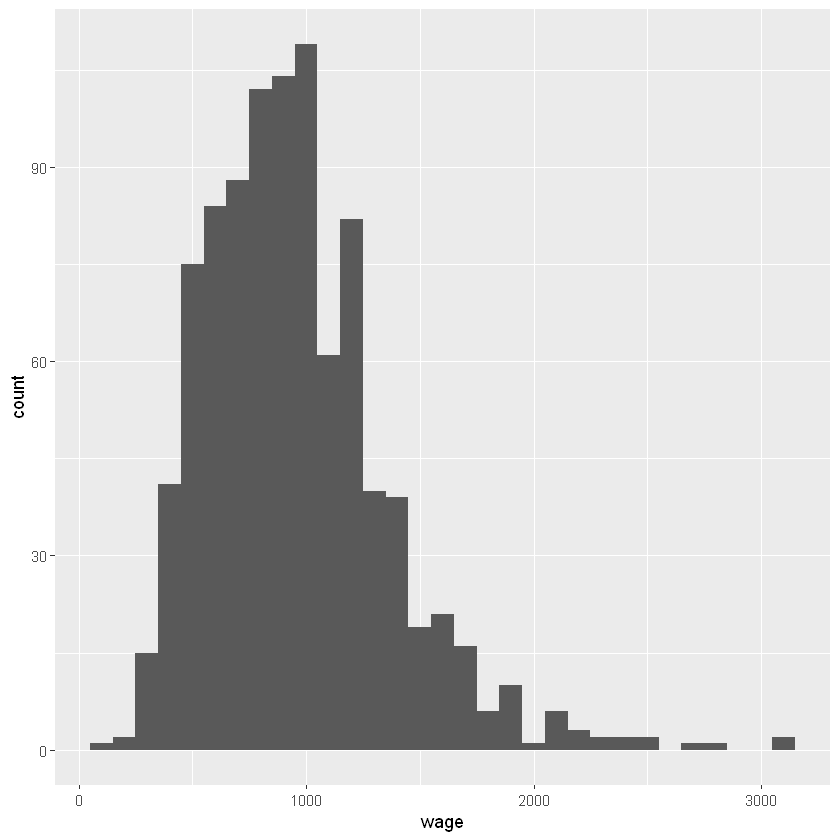

In [4]:
ggplot(data = wage, aes(x = wage)) +
  geom_histogram(binwidth = 100)

For numeric summary statistics, the `summary` function provides additional 
insights about the distribution of `wage`.

In [5]:
summary(wage$wage)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  115.0   669.0   905.0   957.9  1160.0  3078.0 

**Which of the following statements is *true* about the distribution of weekly wages?**

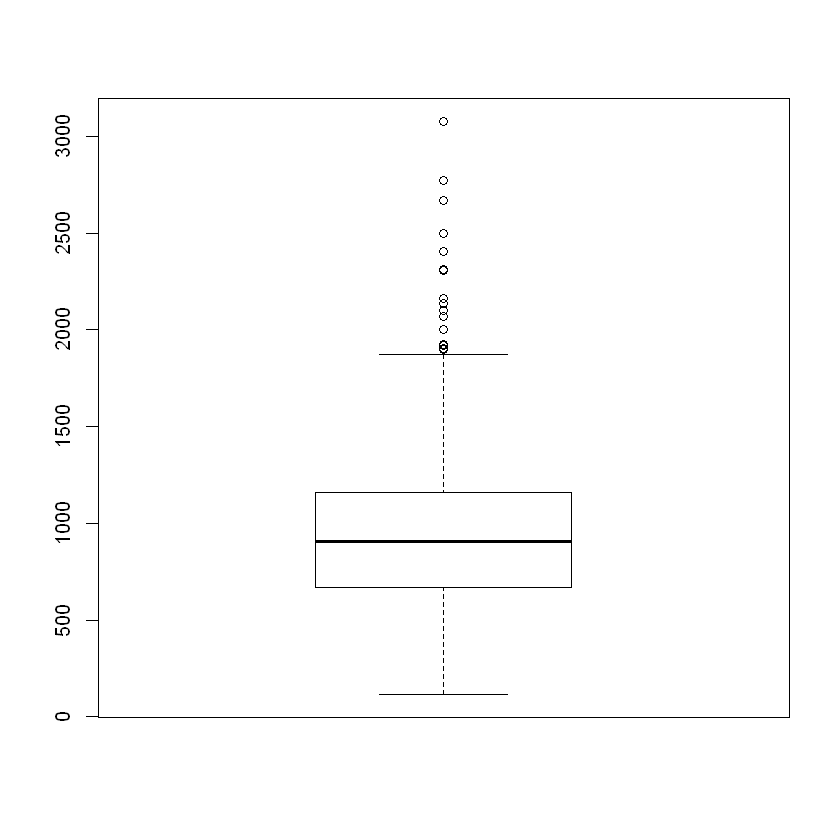

In [6]:
boxplot(wage$wage)

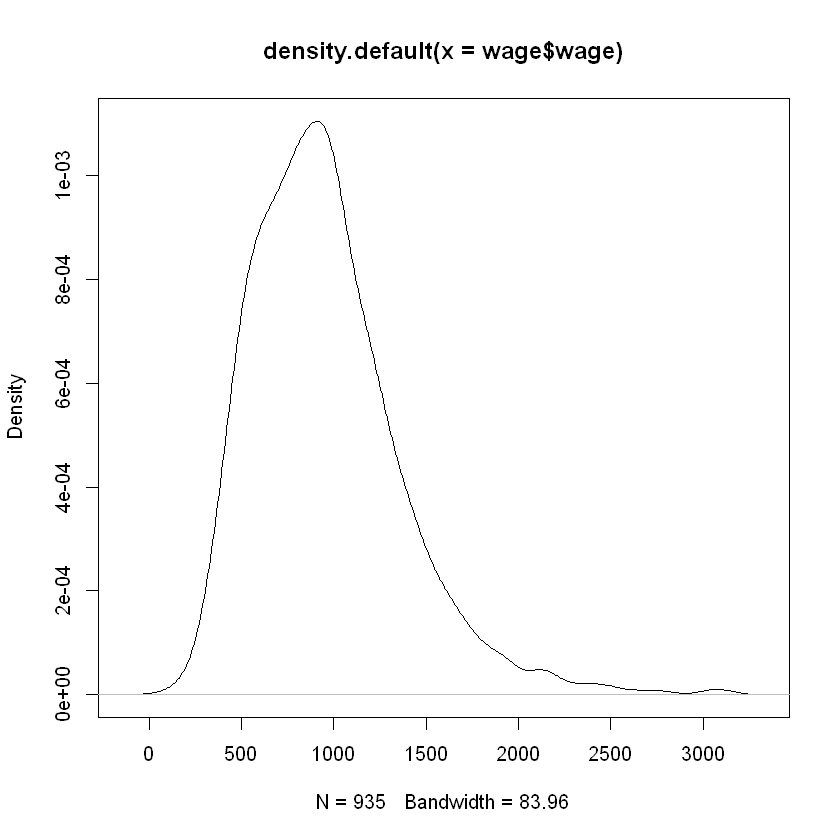

In [7]:
plot(density(wage$wage))

Answer:

    The median of the distribution is 905.
    25\% of respondents make at least 1160 dollars per week.
    `wage` is right-skewed, meaning that more respondents have weekly wages below the mean weekly wage than above it.

## Simple Linear Regression

Since `wage` is our response variable, we would like to explore the relationship 
between `wage` and other variables as predictors. One possible, simplistic, 
explanation for the variation in wages that we see in the data is that smarter 
people make more money. The plot below visualizes a scatterplot between weekly 
wage and IQ score.

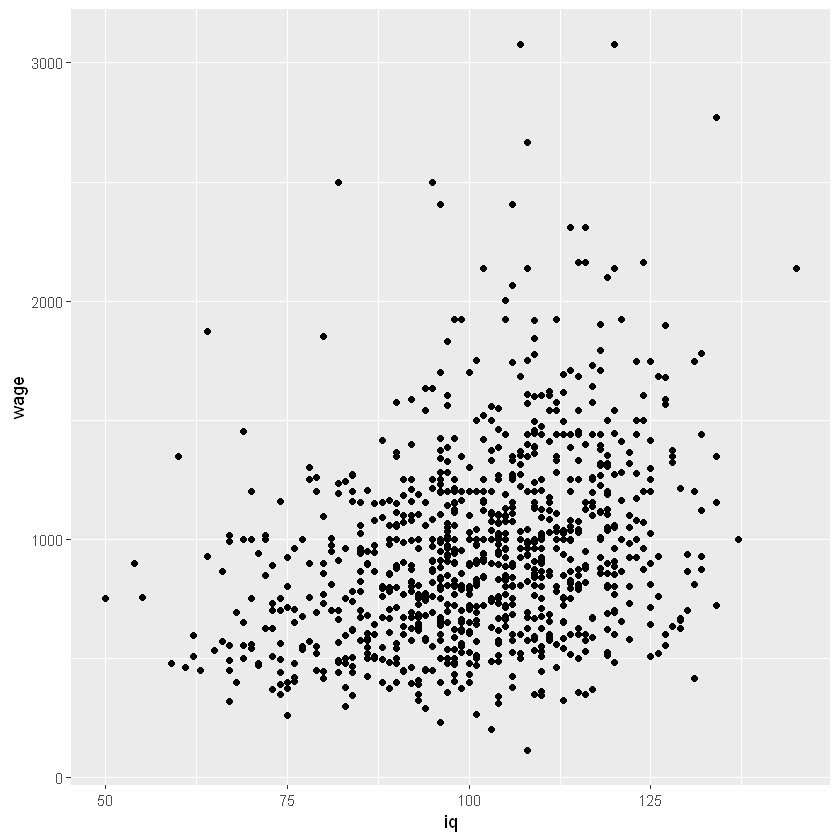

In [8]:
ggplot(data = wage, aes(x = iq, y = wage)) +
  geom_point()

There appears to be a positive relationship between IQ score and wage. We can 
quantify this by fitting a Bayesian simple linear regression 

$$\text{wage}_i = \alpha + \beta \cdot \text{iq}_i + \epsilon_i$$ 

to the observed data using the reference prior. We can fit the model using the 
`lm` function: 

In [9]:
m_wage_iq <- lm(wage ~ iq, data = wage)

and extract the summary statistics for the posterior distribution using the 
output from the `lm` by applyting the `tidy` function from the `broom` package.

In [10]:
tidy(m_wage_iq)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),116.991565,85.6415293,1.366061,1.722489e-01
iq,8.303064,0.8363951,9.927203,3.794935e-22


The first column displays the posterior means of the linear model's y-intercept 
and the regression coefficient of `iq`.

With this we can write down the posterior mean of the regression line

    round(summary(m_wage_iq)$coefficients[1,1],3)

    round(summary(m_wage_iq)$coefficients[2,1],3)

and create a scatterplot with the posterior mean for the regression line laid 
on top.

In [11]:
round(summary(m_wage_iq)$coefficients[1,1],3)

[1] 116.992

In [12]:
round(summary(m_wage_iq)$coefficients[2,1],3)

[1] 8.303

`geom_smooth()` using formula 'y ~ x'



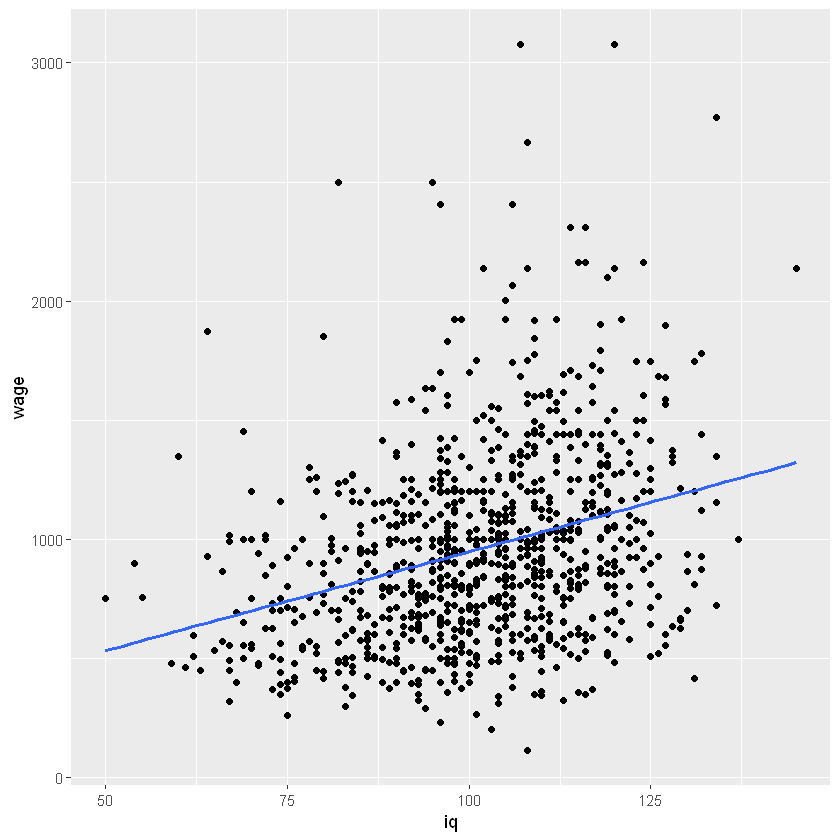

In [13]:
ggplot(data = wage, aes(x = iq, y = wage)) +
  geom_point() +
  stat_smooth(method = "lm", se = FALSE)

Under the assumption that the errors $\epsilon_i$ are independent and normally 
distributed with mean zero and an unknown variance $\sigma^2$, the posterior 
distributions for the intercept and slope  will have a Student-t distribution 
under the reference prior with the posterior means and scales equal to the 
ordinary least squares estimates and standard errors respectively. We can create 
95% credible intervals for the two parameters using the `confint` function:

In [14]:
confint(m_wage_iq)

,2.5 %,97.5 %
(Intercept),-51.080781,285.063910
iq,6.661631,9.944498


Fit a new model that uses `educ` (education) to predict average weekly wages. 
Using the estimates from the R output, write the equation of the posterior mean 
of the regression line and obtain a 95% credible interval for the coefficients. 
**What does the slope tell us in the context of the relationship between education
and earnings?**

In [15]:
m_wage_educ <- lm(wage ~ educ, data = wage)

tidy(m_wage_educ)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),146.95244,77.714957,1.890916,5.894519e-02
educ,60.21428,5.694982,10.573218,9.345036e-25


In [16]:
confint(m_wage_educ)

,2.5 %,97.5 %
(Intercept),-5.56393,299.46881
educ,49.03783,71.39074


In [17]:
round(summary(m_wage_educ)$coefficients[1,1],3)

[1] 146.952

In [18]:
round(summary(m_wage_educ)$coefficients[2,1],3)

[1] 60.214

    Answer: Each additional year of education increases weekly wages by $60.21.

## Model diagnostics

The Bayesian model specification assumes that the errors are normally 
distributed with a constant variance and that the mean expected weekly wages is 
linear in IQ.  We can check these assumption by examining the distribution of 
the residuals for the model.

In order to do so we will use predicted values, residuals, and standardized 
residuals of the model we fit earlier. The `augment` function in the `broom` 
package is going to come in handy here as it takes in a model object (the output 
of an `lm`) and returns a data frame with columns correspinding to variables 
in the model as well as predicted values (`.fitted`), residuals (`.resid`), and 
standardized residuals (`.std.resid`), along with a few others.

In [19]:
m_wage_iq_aug <- augment(m_wage_iq)

**Linearity and Constant Variance**: You already checked if the relationship 
between weekly wages and IQ is linear using a scatterplot. We should also verify 
this condition with a plot of the residuals vs. fitted (predicted) values.

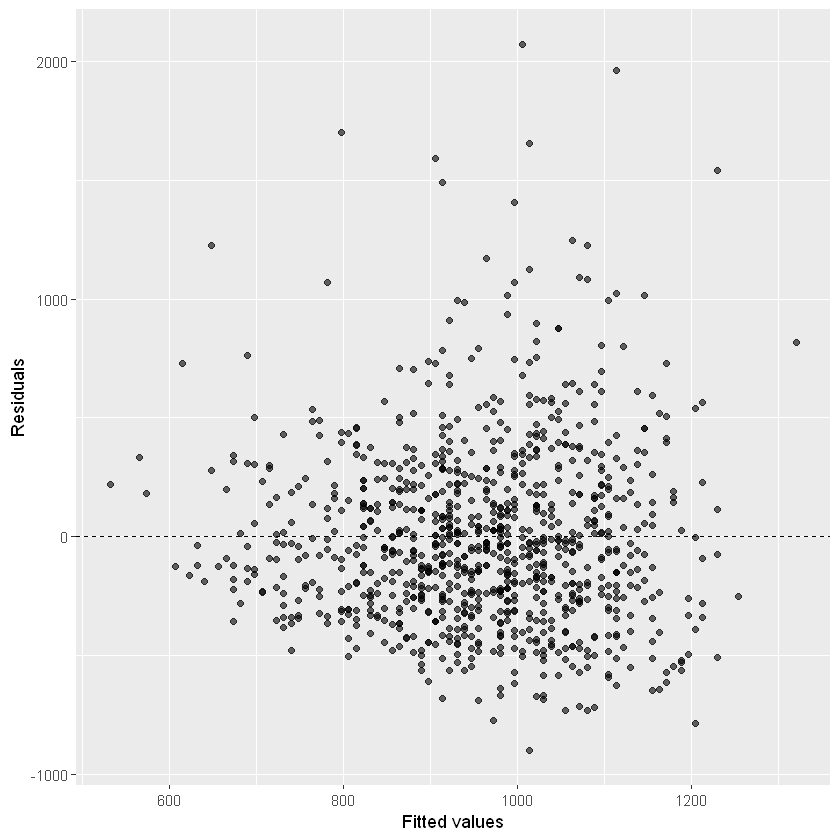

In [20]:
ggplot(data = m_wage_iq_aug, aes(x = .fitted, y = .resid)) +
  geom_point(alpha = 0.6) +
  geom_hline(yintercept = 0, linetype = "dashed") +
  labs(x = "Fitted values", y = "Residuals")

Also note that we're getting fancy with the code here. We set the `alpha` level 
of our points to a value lower than 1 (`0.6` to be precise) in order to add 
plot the points with some transparency. This will allow us to more easily 
identify where the points are more dense vs. more sparse. Then, we overlay a 
horizontal dashed line at $y = 0$ (to help us check whether residuals are 
distributed evenly around 0 at each fitted value), and we also adjust the axis 
labels to be more informative.

**Normality**: To check this condition, we can look at a histogram of residuals

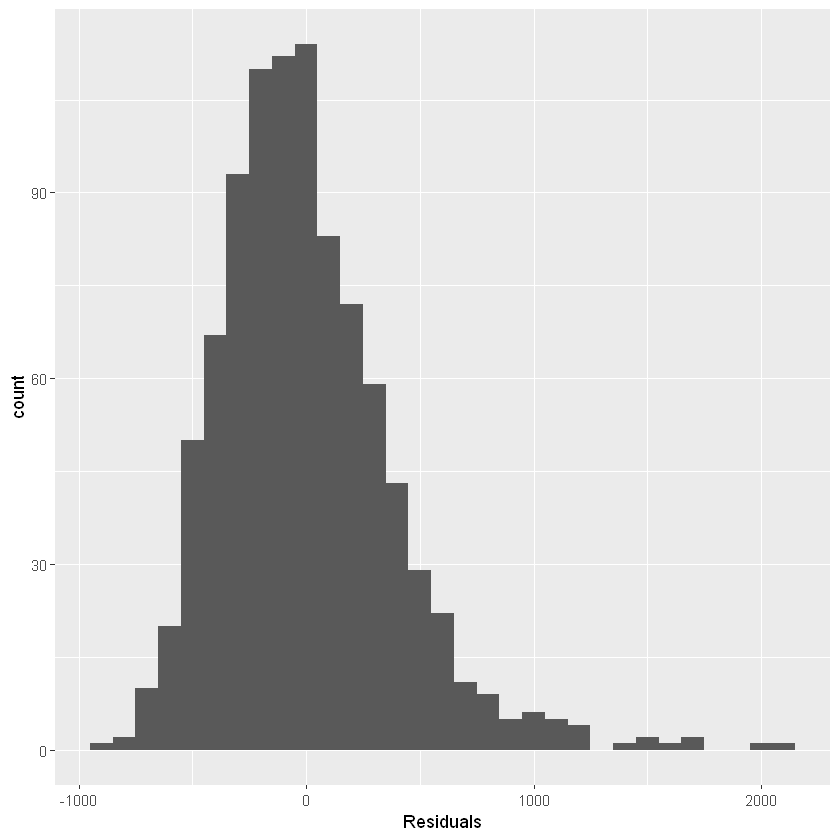

In [21]:
ggplot(data = m_wage_iq_aug, aes(x = .resid)) +
  geom_histogram(binwidth = 100) +
  xlab("Residuals")

or a normal probability plot of the residuals

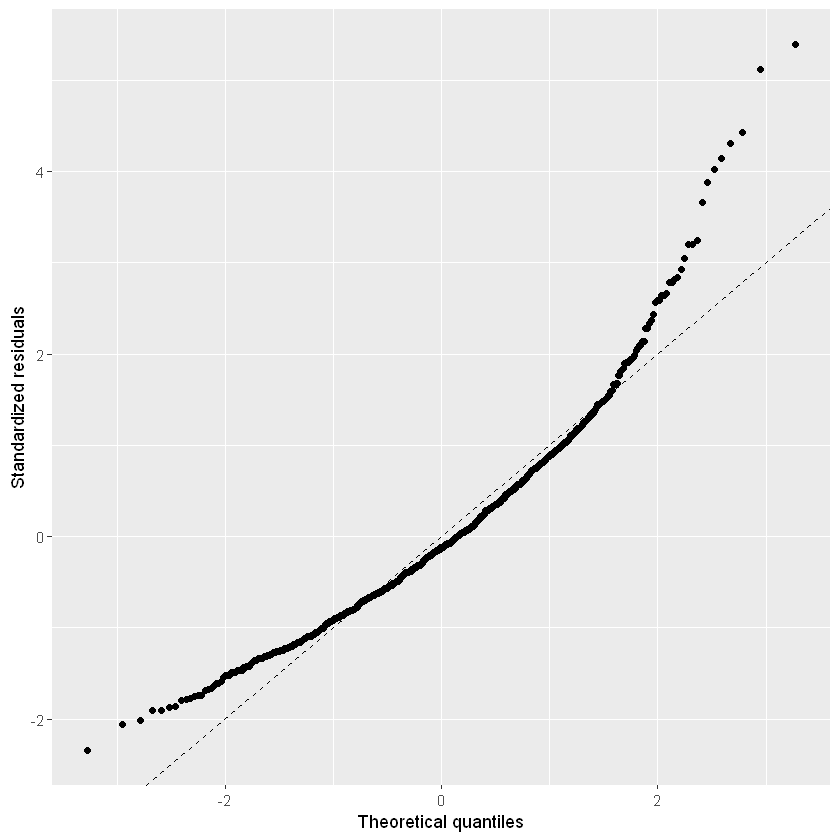

In [22]:
ggplot(m_wage_iq_aug) +
  geom_qq(aes(sample = .std.resid)) +
  geom_abline(slope = 1, intercept = 0, linetype = "dashed") +
  labs(x = "Theoretical quantiles", y = "Standardized residuals")

Where we expect the points to be close to the dashed line, if the assumption of 
normality holds. Note that the $y$-axis in the plot uses standardized residuals, 
which are the residuals divided by their standard deviations so that they will 
have a normal distribution with mean zero and constant variance if the model 
holds.

**Which of the following statements about the residual plots are *True*?**

Answer:

    -The residuals appear to be randomly distributed around 0.
    -The variability of residuals appears to increase as the fitted  increase, suggesting that the constant variance assumption does not hold.
    -There are more individuals where the model under predicts weekly wages rather than over estimates weekly wages.

**Refit the model by using `educ` (education) as the independent variable.**

In [23]:
m_wage_educ_aug <- augment(m_wage_educ)

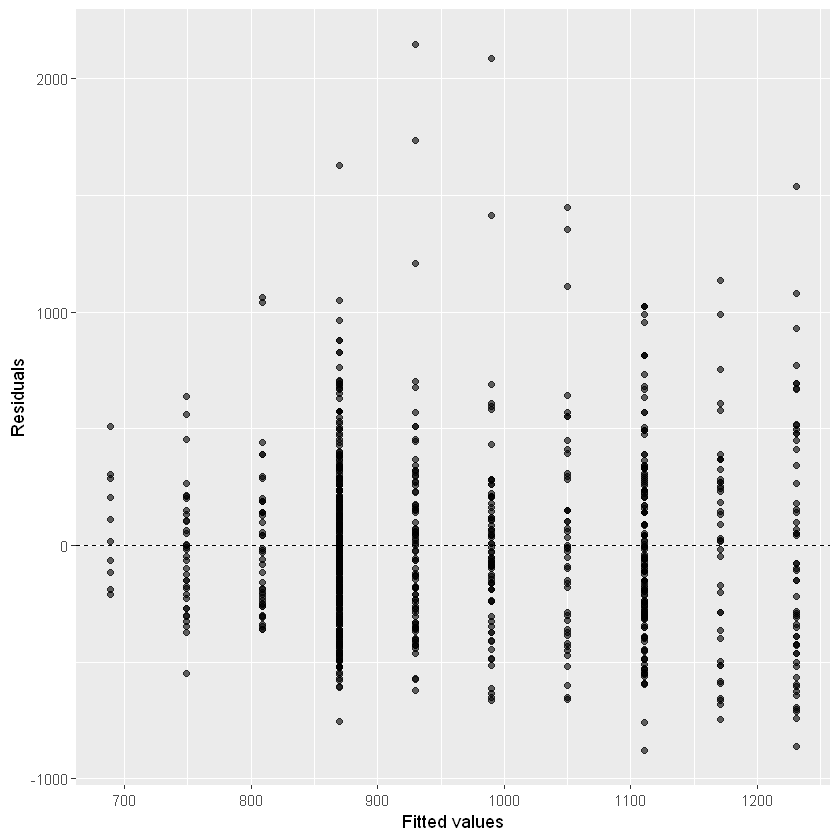

In [24]:
ggplot(data = m_wage_educ_aug, aes(x = .fitted, y = .resid)) +
  geom_point(alpha = 0.6) +
  geom_hline(yintercept = 0, linetype = "dashed") +
  labs(x = "Fitted values", y = "Residuals")

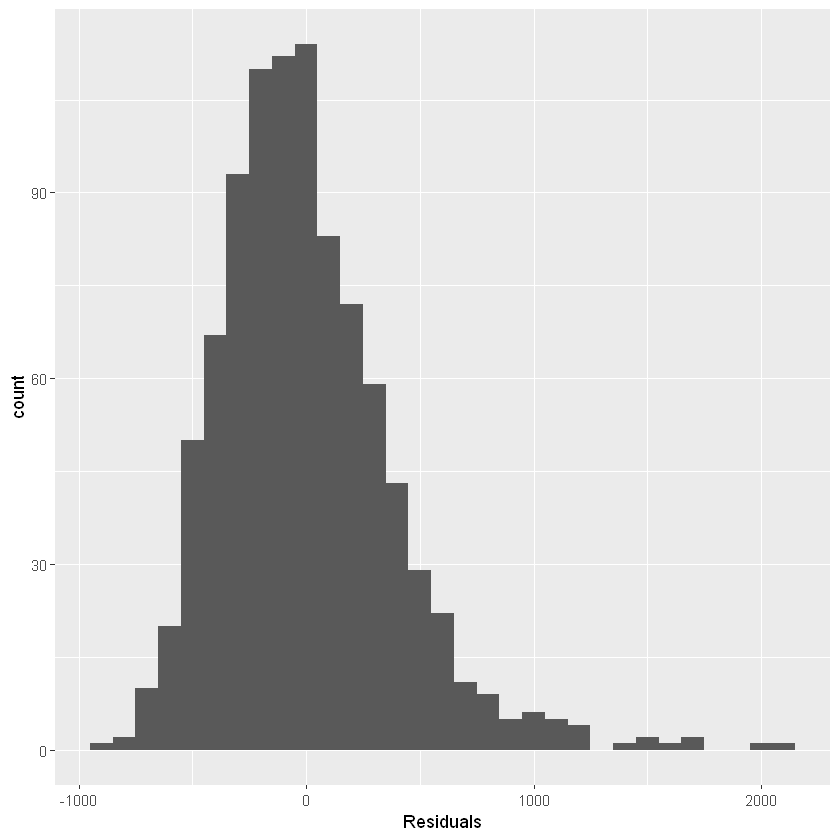

In [25]:
ggplot(data = m_wage_iq_aug, aes(x = .resid)) +
  geom_histogram(binwidth = 100) +
  xlab("Residuals")

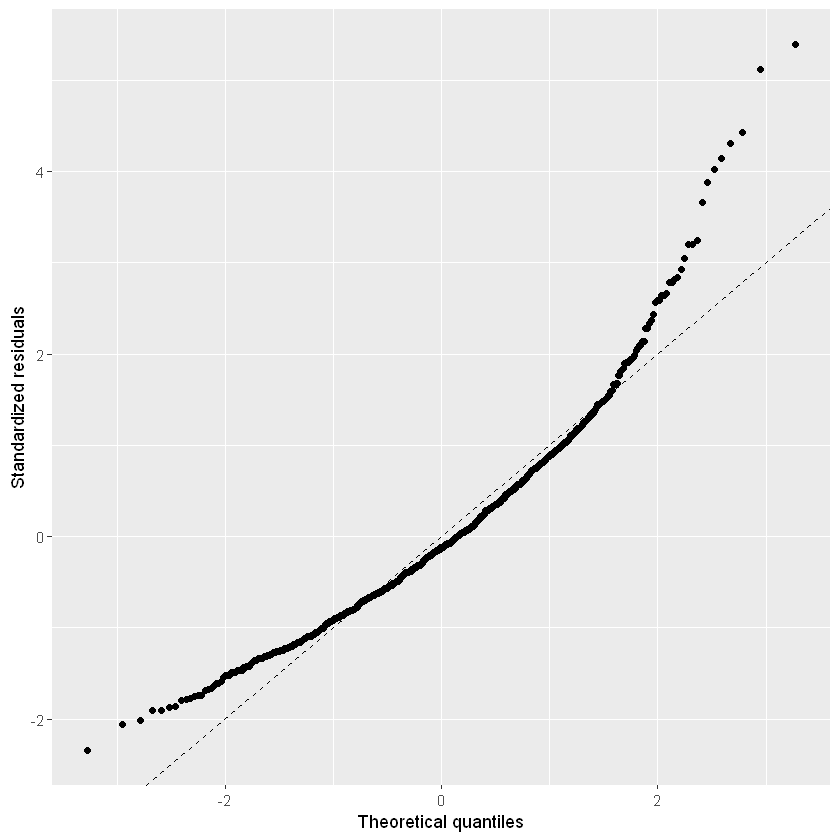

In [26]:
ggplot(m_wage_iq_aug) +
  geom_qq(aes(sample = .std.resid)) +
  geom_abline(slope = 1, intercept = 0, linetype = "dashed") +
  labs(x = "Theoretical quantiles", y = "Standardized residuals")

## Linear Regression After Transforming `wage`

One way to accommodate the right-skewness in the residuals is to (natural) 
log-transform the dependent variable. Note that this is only possible if the 
variable is strictly positive, since the log of negative value is not defined 
and $\ln(0) = -\infty$. Let us try to fit a linear model with log-wage (`lwage`) 
as the dependent variable. The next two questions will be based on this log 
transformed model.

In [27]:
m_lwage_iq = lm(lwage ~ iq, data = wage)

**Examine the residuals of this model. Is the assumption of normally distributed 
residuals reasonable?**

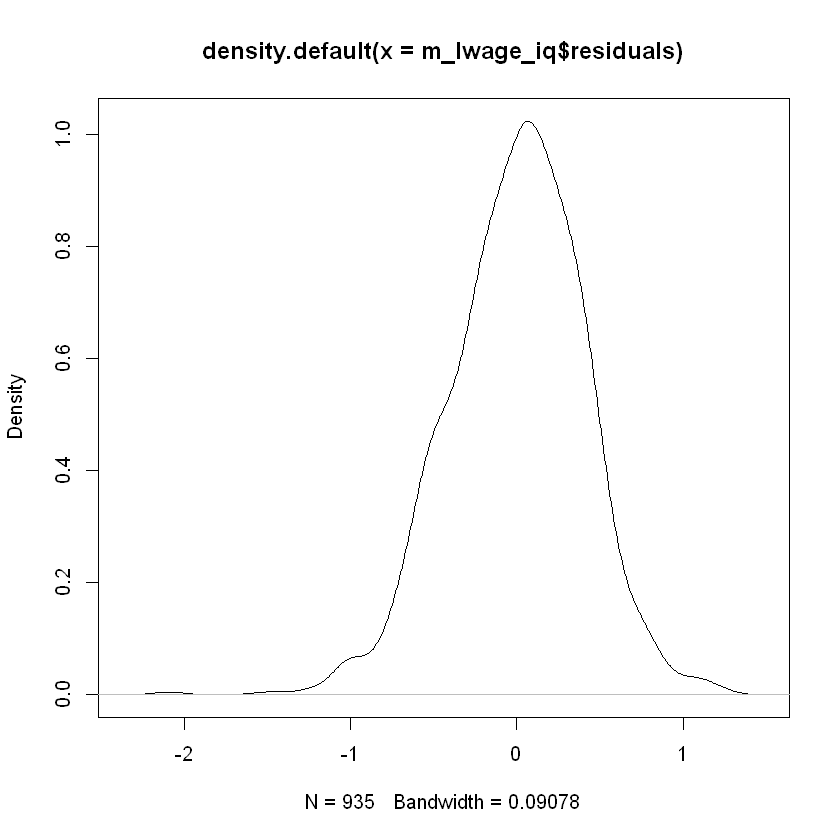

In [28]:
plot(density(m_lwage_iq$residuals))

    Answer: Yes.

Recall that the posterior distribution of $\alpha$ and $\beta$ given $\sigma^2$ is normal, but marginally follows a $t$ distribution with $n-p-1$ degrees of freedom.  In this case, $p=1$, since IQ is the only predictor of log-wage included in our model. Therefore both $\alpha$ and $\beta$ will have a posteriors that follow a $t$ distribution 933 degrees of freedom - since the df is so large these distributions will actually be approximately normal.

**Under the reference prior $p(\alpha, \beta, \sigma^2) \propto 1/\sigma^2$, give a 95\% posterior credible interval for $\beta$, the coefficient of IQ.**

In [29]:
summary(m_lwage_iq)


Call:
lm(formula = lwage ~ iq, data = wage)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.09324 -0.25547  0.02261  0.27544  1.21486 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 5.8869942  0.0890206   66.13   <2e-16 ***
iq          0.0088072  0.0008694   10.13   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.3999 on 933 degrees of freedom
Multiple R-squared:  0.09909,	Adjusted R-squared:  0.09813 
F-statistic: 102.6 on 1 and 933 DF,  p-value: < 2.2e-16


In [30]:
inf = 0.0088072-1.96*0.0008694
inf

sup = 0.0088072+1.96*0.0008694
sup


[1] 0.007103176

[1] 0.01051122

    Answer:(0.00709, 0.01050)

The coefficient of IQ is very small, which is expected since a one point increase in IQ score can hardly be expected to have a high multiplicative effect on wage.  One way to make the coefficient more interpretable is to standardize IQ before putting it into the model.  From this new model, an increase in IQ of 1 standard deviation (15 points) is estimated to increase wage by **what percentage?**

In [31]:
wage <- wage %>% mutate(z_iq = (iq - mean(iq)) / sd(iq))

m_wage_ziq = lm(wage ~ z_iq, data = wage)

summary(m_wage_ziq)


Call:
lm(formula = wage ~ z_iq, data = wage)

Residuals:
   Min     1Q Median     3Q    Max 
-898.7 -256.5  -47.3  201.1 2072.6 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   957.95      12.58  76.129   <2e-16 ***
z_iq          124.98      12.59   9.927   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 384.8 on 933 degrees of freedom
Multiple R-squared:  0.09554,	Adjusted R-squared:  0.09457 
F-statistic: 98.55 on 1 and 933 DF,  p-value: < 2.2e-16


## Outliers

We declared observations to be outliers with respect to the population model if 
their deviation or error $\epsilon_i$ was more than $k=3$ standard deviations 
above or below 0. Let's use the `Bayes.outlier` function from `BAS`, to calculate 
these probabilities for the model  `m_lwage_iq` and plot them against the 
case number.

We start by calculating the probabilities,

In [32]:
outliers <- Bayes.outlier(m_lwage_iq, k = 3)

and then store the results in a data frame and plot them.

In [33]:
outliers_df <- data.frame(probability = outliers$prob.outlier, case = 1:length(outliers$prob.outlier))

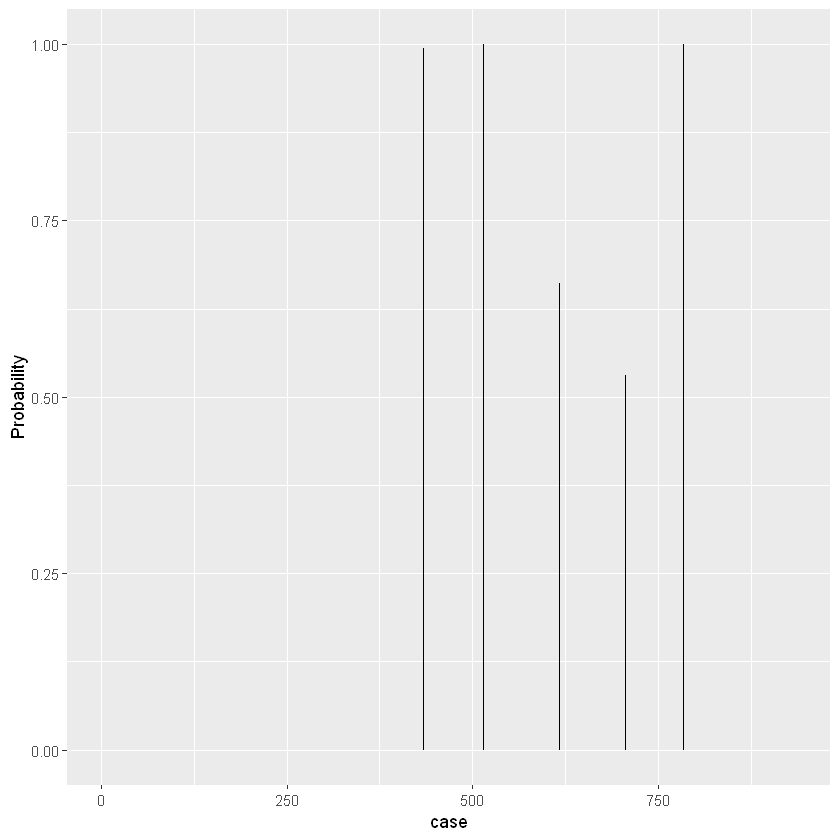

In [34]:
ggplot(outliers_df, aes(ymax = probability, x = case)) +
  geom_linerange(ymin = 0) +
  labs(y = "Probability")

To identify which cases have probabilities greater than 0.50 of being an outlier, 
we can use the `filter` function to return which cases have `probability > 0.50`.

In [35]:
outliers_df %>%
  filter(probability > 0.50)

probability,case
<dbl>,<int>
0.9937375,434
1.0000000,514
0.6610078,616
0.5309985,705
1.0000000,784


**Using the definition of outlier above, which statement is *true*?**

Answer:

    -Case 434 has a probability of close to 1 that it an outlier under the normal error model for regressing `lwage` on `iq`
    -Case 514 has a probably of close to 1 that it an outlier under the normal error model for regressing `lwage` on `iq`
    -Case 784 has a probably of close to 1 that it an outlier under the normal error model for regressing `lwage` on `iq`

While being $3$ standard deviations seems like an extremely unlikely event for 
a single observation, for large sample sizes, there is often a rather high 
probability that there will be at least one error $\epsilon_i$ that exceeds $3$ 
standard deviations above or below zero _a priori_. We can calculate this as 
follows

In [36]:
# prob of a case being an outlier:
#   being below or above 3 standard deviations from 0
(prob_outlier <- pnorm(-3) + pnorm(3, lower.tail = FALSE))

# probability of a signle case not being an outler is therefore the complement 
(prob_not_outlier <- 1 - prob_outlier)

# probability of no outliers in the sample of n assuming errors are independent a priori
n <- nrow(wage)
(prob_no_outliers <- prob_not_outlier^n)

# probability of at least one outlier in the sample is the complement of the 
# probability of no outliers in the sample of n
1 - prob_no_outliers

[1] 0.002699796

[1] 0.9973002

[1] 0.07984061

[1] 0.9201594

With a sample size of `r nrow(wage)` and using $3$ standard deviations to 
define outliers, the chance of having at least one outlier in the sample is 
`r round((1 - prob_no_outliers)*100, 2)`% so the fact that we did discover some 
outliers is not that surprising. 

So instead of fixing the number of standard deviations to $k=3$, an alternative 
is fix the prior probability of there being no outliers in the sample, 

$$P(\text{no outliers in sample}) = P(\text{observation is not an outlier})^n = 0.95$$

which we can solve for

$$ P(\text{observation is not an outlier}) = 0.95^{1/n} $$

and then solve for  $k$ using the normal quantile function.

In [37]:
n <- nrow(wage)
(prob_obs_not_outlier <- 0.95^(1/n))
(newk <- qnorm(0.5 + 0.5 * prob_obs_not_outlier))

[1] 0.9999451

[1] 4.033904

The function `Bayes.outlier` can also calculate `k` internally if we specify 
the prior probability of there being no outliers in the sample:

In [38]:
outliers <- Bayes.outlier(m_lwage_iq, prior.prob=0.95)

**Use the new value of $k$ to calculate the posterior probability of each observation being an 
outlier. Which observation has a posterior probability of being an outlier 
that exceeds the prior probability of being an outlier?**

In [39]:
outliers_df <- data.frame(probability = outliers$prob.outlier, case = 1:length(outliers$prob.outlier))

In [40]:
outliers_df %>%
  filter(probability > 0.50)

probability,case
<dbl>,<int>
1,784


    Answer: Case 784

## Multiple Linear Regression

It is evident that wage can be explained by many predictors, such as experience, education, IQ, and so on. We can include all relevant covariates in a regression model in an attempt to explain as much wage variation as possible. In addition, sometimes outliers can be explained by changing the model by adding other predictors; let's take a look at multiple regression before removing any cases. 

In [41]:
m_lwage_full <- lm(lwage ~ . - wage, data = wage)

The use of `. - wage` in the `lm` function tells R to include all covariates in 
the model except the `wage` variable from the data set.

However, running this full model has a cost: we will remove observations from 
our data if some measurements in the variables (e.g. birth order, mother's 
education, and father's education) are missing. By default, the `lm` function 
does a complete-case analysis. So it removes any observations with a missing 
(`NA`) value in one or more of the predictor variables. 

Because of these missing values we must make an addition assumption in order 
for our inferences to be valid. This exclusion of rows with missing values 
requires that in the data there is no systematic reason for the values to be 
missing. In other words, our data must be missing at random. For example, if 
all first-born children did not report their birth order, the data would not 
be missing at random. Without any additional information we will assume this 
is reasonable and use the 663 complete observations (as opposed to the original 
935) to fit the model. Both Bayesian and frequentist methods exist to handle 
data sets with missing data, but they are beyond the scope of this course. 

In [42]:
summary(m_lwage_full)


Call:
lm(formula = lwage ~ . - wage, data = wage)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.96887 -0.19460  0.00923  0.22401  1.34185 

Coefficients: (1 not defined because of singularities)
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  5.156439   0.225286  22.888  < 2e-16 ***
hours       -0.006548   0.001934  -3.385 0.000754 ***
iq           0.003186   0.001223   2.604 0.009425 ** 
kww          0.003735   0.002390   1.562 0.118662    
educ         0.041267   0.008942   4.615 4.74e-06 ***
exper        0.010749   0.004435   2.424 0.015629 *  
tenure       0.007102   0.002894   2.454 0.014401 *  
age          0.009107   0.005977   1.524 0.128058    
married1     0.200760   0.045998   4.365 1.48e-05 ***
black1      -0.105141   0.055667  -1.889 0.059373 .  
south1      -0.049076   0.030753  -1.596 0.111019    
urban1       0.195658   0.031240   6.263 6.88e-10 ***
sibs         0.009619   0.007876   1.221 0.222423    
brthord     -0.018465   0.011569 

**From the model, all else begin equal, who would you expect to make more: a married black man or a single non-black man?**

    Answer: The married black man

As you can see from a quick summary of the full linear model, many coefficients  of independent variables are not statistically significant. In previous labs within this specialization, you selected variables based on the values of Adjusted $R^2$. This module introduced the Bayesian Information Criterion (BIC), which is a criterion that can be used for model selection. BIC is based on model fit, while simultaneously penalizing the number of parameters in proportion to the sample size. We can calculate the BIC of the full linear model using the command below:

In [43]:
BIC(m_lwage_full)

[1] 586.3732

We can compare the BIC of the full model with that of a reduced model. Let us try to remove birth order from the model. To ensure that the observations remain the same, the data set can be specified as `na.omit(wage)`, which includes only the observations with no missing values in any variables in the data set.

In [44]:
m_lwage_nobrthord <- lm(lwage ~ . - wage - brthord, data = na.omit(wage))

BIC(m_lwage_nobrthord)

[1] 582.4815

As you can see, removing birth order from the regression reduces BIC, which we seek to minimize by model selection.

**Elimination of which variable from the full model yielded the lowest BIC?**

In [45]:
vbrthord = BIC(lm(lwage ~ . -wage -brthord, data = na.omit(wage)))

vsibs = BIC(lm(lwage ~ . -wage -sibs, data = na.omit(wage)))

vfeduc = BIC(lm(lwage ~ . -wage -feduc, data = na.omit(wage)))

vmeduc = BIC(lm(lwage ~ . -wage -meduc, data = na.omit(wage)))

paste("BIC without brthord",vbrthord)
paste("BIC without sibs",vsibs)
paste("BIC without feduc",vfeduc)
paste("BIC without meduc",vmeduc)

[1] "BIC without brthord 582.481519382231"

[1] "BIC without sibs 581.403065169494"

[1] "BIC without feduc 580.974349750992"

[1] "BIC without meduc 582.37220008543"

    Answer: feduc

R has a function `stepAIC` from the `MASS` package that will work backwards 
through the model space, removing variables until the AIC score can be no longer 
lowered. It takes all inputs in the full model, and a penalty parameter $k$. 
The default setting is $k=2$ for the AIC score. Find the best model according 
to BIC (in which case `k = log(n)` where $n$ is the number of observations). 
Remember to use `na.omit(wage)` as your data set. You may type `?stepAIC` in 
the RStudio Console to get the use and examples of the function `stepAIC`. 

In [46]:
wage_no_na <- na.omit(wage)

k = log(dim(wage_no_na)[1])

stepAIC(lm(formula = lwage ~ . - wage, data = wage_no_na))

Start:  AIC=-1373.58
lwage ~ (wage + hours + iq + kww + educ + exper + tenure + age + 
    married + black + south + urban + sibs + brthord + meduc + 
    feduc + z_iq) - wage


Step:  AIC=-1373.58
lwage ~ hours + iq + kww + educ + exper + tenure + age + married + 
    black + south + urban + sibs + brthord + meduc + feduc

          Df Sum of Sq    RSS     AIC
- feduc    1    0.1319 79.710 -1374.5
- sibs     1    0.1835 79.761 -1374.1
<none>                 79.578 -1373.6
- age      1    0.2856 79.864 -1373.2
- meduc    1    0.3001 79.878 -1373.1
- kww      1    0.3003 79.878 -1373.1
- south    1    0.3132 79.891 -1373.0
- brthord  1    0.3133 79.891 -1373.0
- black    1    0.4388 80.017 -1371.9
- exper    1    0.7226 80.301 -1369.6
- tenure   1    0.7405 80.319 -1369.4
- iq       1    0.8340 80.412 -1368.7
- hours    1    1.4096 80.988 -1363.9
- married  1    2.3430 81.921 -1356.3
- educ     1    2.6196 82.198 -1354.1
- urban    1    4.8246 84.403 -1336.6

Step:  AIC=-1374.49
lwage ~


Call:
lm(formula = lwage ~ hours + iq + kww + educ + exper + tenure + 
    age + married + black + south + urban + meduc, data = wage_no_na)

Coefficients:
(Intercept)        hours           iq          kww         educ        exper  
   5.134460    -0.006371     0.003273     0.003546     0.042825     0.010333  
     tenure          age     married1       black1       south1       urban1  
   0.006943     0.009068     0.203743    -0.096556    -0.057885     0.196127  
      meduc  
   0.013480  


## Bayesian Model Averaging

Often, several models are equally plausible and choosing only one ignores the 
inherent uncertainty involved in choosing the variables to include in the model. 
A way to get around this problem is to implement Bayesian model averaging (BMA), 
in which multiple models are averaged to obtain posteriors of coefficients and 
predictions from new data. Dr. Merlise Clyde is the primary author of the R 
package `BAS`, which implements BMA [@Clyde2018]. We can use this for either 
implementing BMA or selecting models.

We start by applying BMA to the wage data using all $15$ potential predictors.

In [47]:
# Exclude observations with missing values in the data set
wage_no_na <- na.omit(wage)

# Fit the model using Bayesian linear regression, `bas.lm` function in the `BAS` package
bma_lwage <- bas.lm(lwage ~ . -wage, data = wage_no_na,
                   prior = "BIC", 
                   modelprior = uniform())

# Print out the marginal posterior inclusion probabilities for each variable                
bma_lwage

# Top 5 most probably models
summary(bma_lwage)


Call:
bas.lm(formula = lwage ~ . - wage, data = wage_no_na, prior = "BIC", 
    modelprior = uniform())


 Marginal Posterior Inclusion Probabilities: 
Intercept      hours         iq        kww       educ      exper     tenure  
   1.0000     0.8523     0.6422     0.3186     0.9988     0.6964     0.7090  
      age   married1     black1     south1     urban1       sibs    brthord  
   0.5502     0.9990     0.3236     0.3090     1.0000     0.0414     0.1207  
    meduc      feduc       z_iq  
   0.5709     0.2332     0.6422  

,P(B != 0 | Y),model 1,model 2,model 3,model 4,model 5
Intercept,1.00000000,1.0000,1.0000,1.0000,1.0000000,1.0000000
hours,0.85234234,1.0000,1.0000,1.0000,1.0000000,1.0000000
iq,0.64217314,1.0000,1.0000,0.0000,0.0000000,1.0000000
kww,0.31864939,0.0000,0.0000,0.0000,0.0000000,0.0000000
educ,0.99878876,1.0000,1.0000,1.0000,1.0000000,1.0000000
exper,0.69642238,0.0000,0.0000,0.0000,1.0000000,1.0000000
tenure,0.70896475,1.0000,1.0000,1.0000,1.0000000,1.0000000
age,0.55016766,1.0000,1.0000,1.0000,1.0000000,1.0000000
married1,0.99896746,1.0000,1.0000,1.0000,1.0000000,1.0000000
black1,0.32364267,0.0000,0.0000,0.0000,0.0000000,0.0000000


Printing the model object and the summary command gives us both the posterior 
model inclusion probability for each variable and the most probable models. For 
example, the posterior probability that `hours` is included in the model is 
0.855. Further, the most likely model, which has posterior probability of 0.0455, 
includes an intercept, hours worked, IQ, education, tenure, age, marital status, 
urban living status, and mother's education. While a posterior probability of 
0.0455 sounds small, it is much larger than the uniform prior probability 
assigned to it, since there are $2^{15}$ possible models. 

It is also possible to visualize the posterior distribution of the coefficients 
under the model averaging approach. We graph the posterior distribution of the 
coefficients of `iq` and `sibs` below. Note that the subset command dictates 
which variable is plotted.

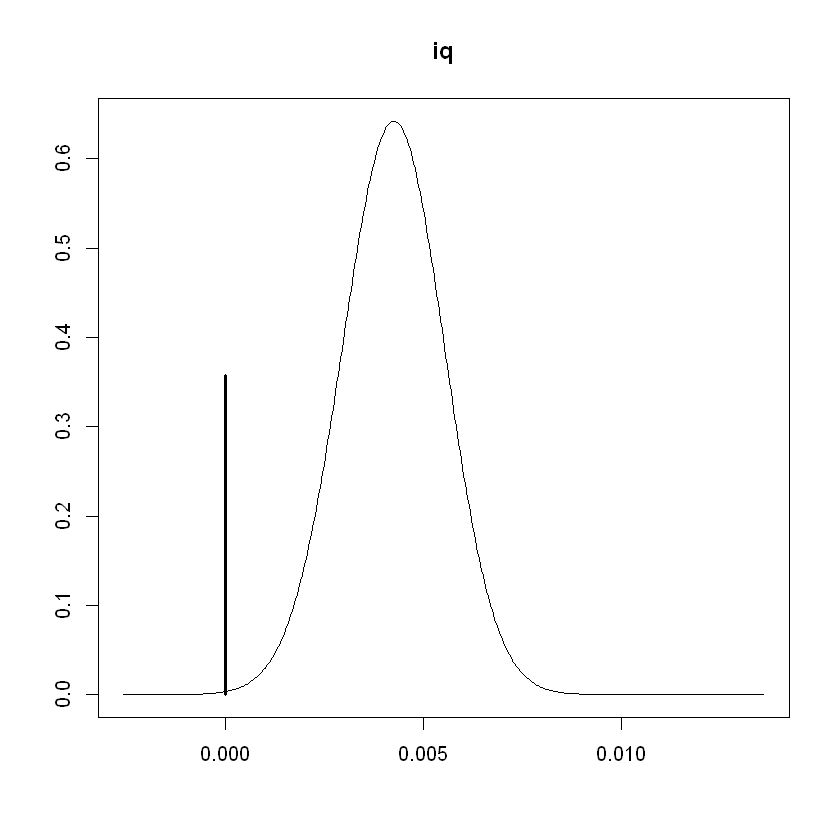

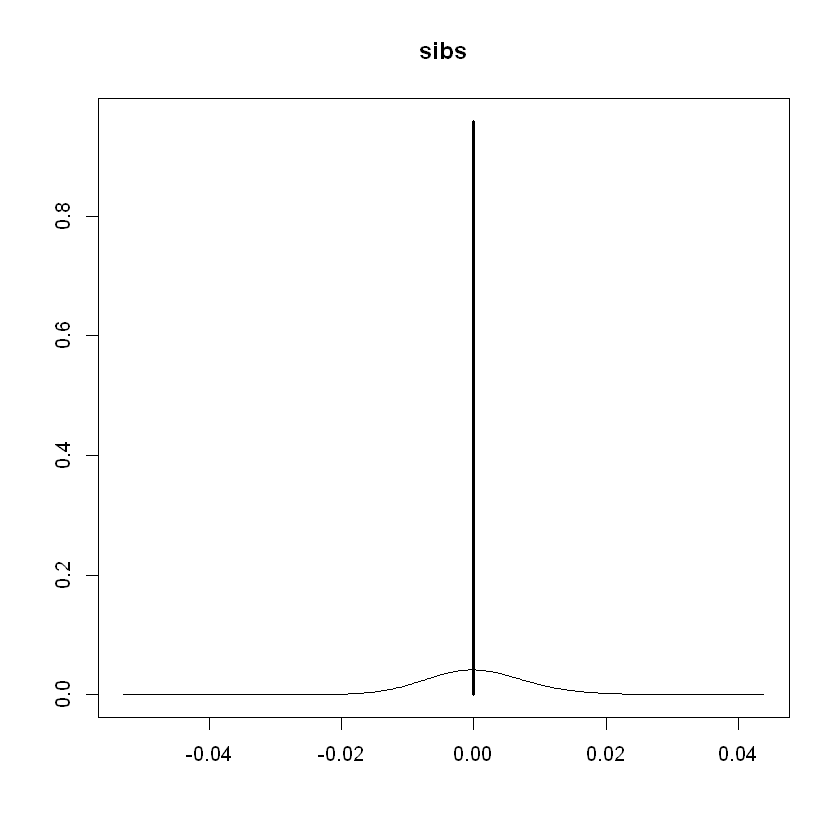

In [48]:
# Obtain the coefficients from the model `bma_lwage`
coef_lwage <- coefficients(bma_lwage)

# `iq` is the 3rd variable, while `sibs` is the 13th variable in the data set
plot(coef_lwage, subset = c(3,13), ask = FALSE)

We can also provide 95% credible intervals for these coefficients:

In [49]:
confint(coef_lwage)

                   2.5%       97.5%          beta
Intercept  6.786452e+00 6.839981299  6.814297e+00
hours     -9.283565e-03 0.000000000 -5.272412e-03
iq         0.000000e+00 0.006076918  2.718290e-03
kww        0.000000e+00 0.008067752  1.732611e-03
educ       2.152987e-02 0.063925349  4.325343e-02
exper      0.000000e+00 0.021144668  9.805838e-03
tenure    -1.560431e-06 0.012818219  5.990298e-03
age        0.000000e+00 0.025771241  9.462841e-03
married1   1.174568e-01 0.299502855  2.094388e-01
black1    -1.840640e-01 0.000000000 -4.003230e-02
south1    -9.975219e-02 0.000000000 -2.108410e-02
urban1     1.376859e-01 0.261674954  1.983711e-01
sibs       0.000000e+00 0.000000000  1.960587e-05
brthord   -1.901691e-02 0.000000000 -1.904623e-03
meduc      0.000000e+00 0.022766908  8.612548e-03
feduc      0.000000e+00 0.015728283  2.516208e-03
z_iq       0.000000e+00 0.083423230  2.045872e-02
attr(,"Probability")
[1] 0.95
attr(,"class")
[1] "confint.bas"

For Questions 9-10, we'll use a reduced data set which excludes wage, number 
of siblings, birth order, and parental education.

In [50]:
wage_red <- wage %>%
  select(-wage, -sibs, -brthord, -meduc, -feduc)

Let's use BMA with the Zellner-Siow prior on the regression coefficients:

In [51]:
bma_lwage_red <- bas.lm(lwage ~ ., data = wage_red, prior = "ZS-null", modelprior = uniform())

**Based on this reduced data set, according to Bayesian model averaging, which of 
the following variables has the lowest marginal posterior inclusion probability?**

In [52]:
wage_red_no_na <- na.omit(wage_red)

bma_lwage2 <- bas.lm(lwage ~ ., data = wage_red_no_na, prior = "BIC", modelprior = uniform())
bma_lwage2


Call:
bas.lm(formula = lwage ~ ., data = wage_red_no_na, prior = "BIC", 
    modelprior = uniform())


 Marginal Posterior Inclusion Probabilities: 
Intercept      hours         iq        kww       educ      exper     tenure  
   1.0000     0.8676     0.6472     0.2974     1.0000     0.9319     0.9980  
      age   married1     black1     south1     urban1       z_iq  
   0.1851     0.9999     0.9748     0.8075     1.0000     0.6472  

In [53]:
summary(bma_lwage2)

,P(B != 0 | Y),model 1,model 2,model 3,model 4,model 5
Intercept,1.0000000,1.0000,1.0000,1.0000,1.0000000,1.0000000
hours,0.8675619,1.0000,1.0000,1.0000,1.0000000,1.0000000
iq,0.6471819,1.0000,1.0000,0.0000,1.0000000,0.0000000
kww,0.2973739,0.0000,0.0000,0.0000,1.0000000,1.0000000
educ,1.0000000,1.0000,1.0000,1.0000,1.0000000,1.0000000
exper,0.9319256,1.0000,1.0000,1.0000,1.0000000,1.0000000
tenure,0.9980101,1.0000,1.0000,1.0000,1.0000000,1.0000000
age,0.1850599,0.0000,0.0000,0.0000,0.0000000,0.0000000
married1,0.9999401,1.0000,1.0000,1.0000,1.0000000,1.0000000
black1,0.9747933,1.0000,1.0000,1.0000,1.0000000,1.0000000


    Answer: 'age'.

**Question: *True* or *False*: The naive model with all variables included has posterior probability greater than 0.5.**

In [54]:
wage_no_na = na.omit(wage)
bma_lwage = bas.lm(lwage ~ . -wage, data = wage_no_na, prior = "ZS-null", modelprior = uniform())
bma_lwage


Call:
bas.lm(formula = lwage ~ . - wage, data = wage_no_na, prior = "ZS-null", 
    modelprior = uniform())


 Marginal Posterior Inclusion Probabilities: 
Intercept      hours         iq        kww       educ      exper     tenure  
   1.0000     0.9404     0.6468     0.4499     0.9995     0.7879     0.8087  
      age   married1     black1     south1     urban1       sibs    brthord  
   0.5943     0.9995     0.4822     0.4708     1.0000     0.1126     0.2411  
    meduc      feduc       z_iq  
   0.6445     0.3300     0.6468  

In [55]:
summary(bma_lwage)

,P(B != 0 | Y),model 1,model 2,model 3,model 4,model 5
Intercept,1.0000000,1.00000,1.00000,1.00000,1.0000000,1.0000000
hours,0.9403577,1.00000,1.00000,1.00000,1.0000000,1.0000000
iq,0.6467805,1.00000,1.00000,0.00000,0.0000000,1.0000000
kww,0.4499473,0.00000,0.00000,0.00000,1.0000000,1.0000000
educ,0.9995308,1.00000,1.00000,1.00000,1.0000000,1.0000000
exper,0.7879441,1.00000,1.00000,1.00000,1.0000000,1.0000000
tenure,0.8086610,1.00000,1.00000,1.00000,1.0000000,1.0000000
age,0.5943058,1.00000,1.00000,1.00000,0.0000000,0.0000000
married1,0.9995018,1.00000,1.00000,1.00000,1.0000000,1.0000000
black1,0.4822493,1.00000,1.00000,1.00000,0.0000000,0.0000000


    Answer:True.

Because we have log transformed wage, interpretation of coefficients from the 
output is not as useful for understanding how the different predictors influence 
wages. Instead we can interpret coefficients after transforming back to the 
original units by exponentiation. The exponential of the posterior mean is not 
the same as the mean of the exponential, however, the median of wage can be 
found by exponentiating the median of log wage (i.e. the middle value is still 
in the middle with transformations that do not change the order of values).  

Let's look at the coefficients and 95% credible intervals

In [56]:
coef(bma_lwage_red)


 Marginal Posterior Summaries of Coefficients: 

 Using  BMA 

 Based on the top  4096 models 
           post mean  post SD    post p(B != 0)
Intercept   6.779004   0.011813   1.000000     
hours      -0.005146   0.002012   0.948275     
iq          0.002222   0.001821   0.654594     
kww         0.002032   0.002478   0.486771     
educ        0.051419   0.007835   1.000000     
exper       0.011782   0.004381   0.950917     
tenure      0.010511   0.002490   0.998747     
age         0.002457   0.004931   0.275032     
married1    0.197511   0.038783   0.999971     
black1     -0.146090   0.043943   0.986137     
south1     -0.073923   0.033790   0.913555     
urban1      0.179189   0.027022   1.000000     
z_iq        0.016722   0.025600   0.654594     

In [57]:
coef(bma_lwage_red) %>%
    confint()

                   2.5%        97.5%         beta
Intercept  6.7567275310  6.803194695  6.779003810
hours     -0.0081622872  0.000000000 -0.005145829
iq         0.0000000000  0.004887178  0.002221780
kww        0.0000000000  0.006795113  0.002031719
educ       0.0361896081  0.066798934  0.051419085
exper      0.0000000000  0.018031157  0.011782139
tenure     0.0055646428  0.015244077  0.010511106
age       -0.0001253006  0.015177609  0.002456995
married1   0.1212628747  0.273112252  0.197511036
black1    -0.2321104723 -0.062881608 -0.146090067
south1    -0.1233207259  0.000000000 -0.073923108
urban1     0.1266652073  0.232643730  0.179189203
z_iq       0.0000000000  0.067741347  0.016721826
attr(,"Probability")
[1] 0.95
attr(,"class")
[1] "confint.bas"

The exponential transformation applied to coefficients has a multiplicative 
effect on the posterior median. What this means is that a one unit increase in 
predictor  $X_j$ leads to a $(\exp(\beta_j) -1) \times 100$ percent increase in 
the median wage [@StatNews83]. For a factor or indicator variable like 
`urban`, the posterior median for wages for urban areas (`urban == 1`) will 
be $(\exp(0.1791) - 1) \times 100$ percent higher than in rural areas 
(`urban == 0`). Similarly we can use the same transformation with the credible 
interval. First, let's calculate the credible interval for the coefficient of 
`urban` and exponentiate it.

In [58]:
ci_urban <- coef(bma_lwage_red) %>%
  confint(parm = "urban1") %>%
  exp()

ci_urban

           2.5%    97.5%     beta
urban1 1.132827 1.259922 1.196247
attr(,"Probability")
[1] 0.95
attr(,"class")
[1] "confint.bas"

Then, we can substract 1 from the bounds of the interval and multipl them by 100 
to make them a bit more straightforward to interpret

In [59]:
(ci_urban - 1) * 100

           2.5%    97.5%     beta
urban1 13.28275 25.99224 19.62471
attr(,"Probability")
[1] 0.95
attr(,"class")
[1] "confint.bas"

Based on this data, there is a 95% chance that median wages for urban areas are

    round((exp(confint(coef(bma_lwage_red), parm='urban1'))[1] - 1)*100, 2)

to 

    round((exp(confint(coef(bma_lwage_red), parm='urban1'))[2] - 1)*100,2)

times higher than in rural regions.

**Find a 95% credible interval for the coefficient of `educ` and provide an interpretation.**

In [60]:
round((exp(confint(coef(bma_lwage_red), parm='educ'))[1] - 1)*100, 2)

[1] 3.69

In [61]:
round((exp(confint(coef(bma_lwage_red), parm='educ'))[2] - 1)*100,2)

[1] 6.88

    Answer: (3.73, 6.89)

## Prediction
A key advantage of Bayesian statistics is prediction and the probabilistic interpretation of predictions.  Much of Bayesian prediction is done using simulation techniques, some of which was discussed near the end of this module.  This is often applied in regression modeling, although we'll work through an example with just an intercept term.

Suppose you observe four numerical observations of $y$, which are 2, 2, 0 and 0 respectively with sample mean $\bar{y} = 1$ and sample variance $s^2 = 4/3$.  Assuming that $y \sim N(\mu, \sigma^2)$, under the reference prior $p(\mu,\sigma^2) \propto 1/\sigma^2$, our posterior becomes


$$\mu|\sigma^2, y \sim N(1, \sigma^2/4)$$
which is centered at the sample mean and 
$$1/\sigma^2, y \sim Gamma(\alpha = 3/2,\beta = 4/2)$$
where $\alpha = (n - 1)/2$ and $\beta = s^2 (n-1)/2 = 2$.

To obtain the predictive distribution for $y_5$, we can first simulate $\sigma^2$ from its posterior and then $\mu$ followed by $y_5$.  Our draws of $y_5$ will be from the posterior predictive distribution for a new observation.  The example below draws 100,000 times from the posterior predictive distribution of $y_5$.

In [62]:
set.seed(314)

N = 100000

phi = rgamma(N,3/2,2)

sigma2 = 1/phi

mu = rnorm(N, 1, sqrt(sigma2/4))

y_5 = rnorm(N, mu, sqrt(sigma2))

We can view an estimate of the predictive distribution, by looking at the a smoothed version of the histogram of the simulated data:

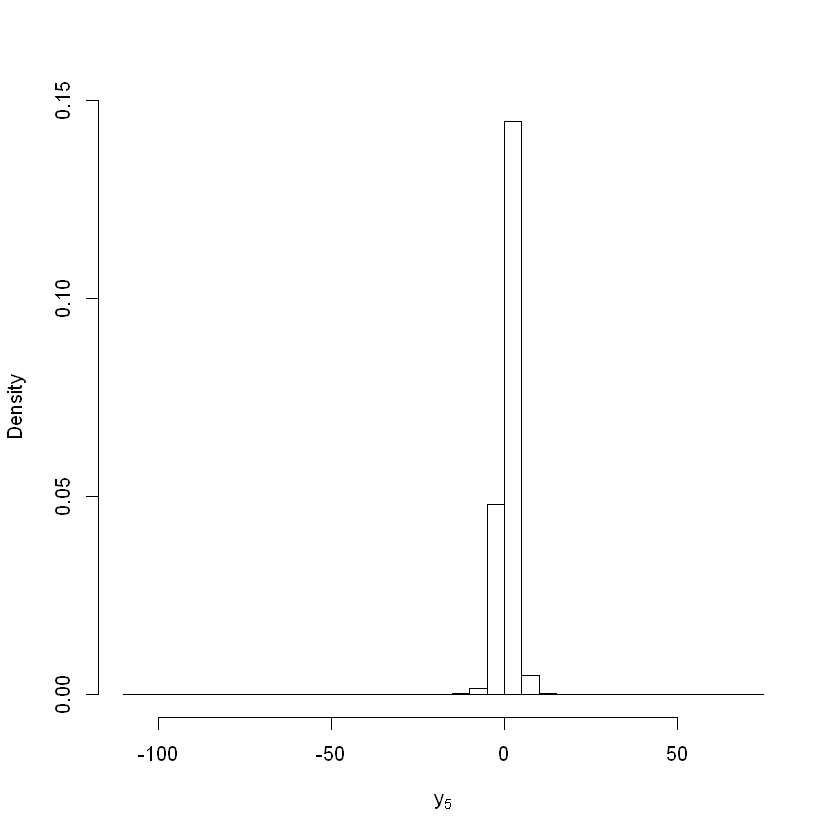

In [63]:
hist(y_5, prob=T, breaks=30, xlab=expression(y[5]), main="")

A 95% central credible interval for a new observation is the interval (L, U) where  $P(Y_5 < L \mid  Y) = .05/2$ and $P(Y_5 > U \mid Y) = .05/2)$.  In this case L is the 0.025 quantile and U is the 0.975 quantile.  We can obtain those values using the `quantile` function to find the sample quantiles for 0.025 and 0.975 of $y_5$.

**Estimate a 95\% central credible interval for a new observation $y_5$**

In [64]:
quantile(y_5, probs = c(0.025, 0.975))

2.5%     97.5% 
-3.109585  5.132511

## Prediction with BAS

Similar to last week's lab, we will be using Bayesian predictive distribution 
for predictions and interpretation of predictions. Simulation is used in `BAS` 
to construct predictive intervals with Bayesian Model Averaging, while exact 
inference is often possible with predictive intervals under model selection.

Returning to the wage data set, let us find the predictive values under the 
*Best Predictive Model* (`BPM`), the one which has predictions closest to BMA 
and corresponding posterior standard deviations.

In [65]:
BPM_pred_lwage <- predict(bma_lwage, estimator = "BPM", se.fit = TRUE)

variable.names(BPM_pred_lwage)

[1] "Intercept" "hours"     "iq"        "kww"       "educ"      "exper"    
 [7] "tenure"    "age"       "married1"  "black1"    "south1"    "urban1"   
[13] "meduc"     "feduc"

In the code above, the function `variable.names` can be used to extract the names of all of the predictors in the Best Probabilty model. This can be used to identify the variables in the  *Highest Probability Model* (`HPM`) 

In [66]:
HPM_pred_lwage <- predict(bma_lwage, estimator = "HPM")

variable.names(HPM_pred_lwage)

[1] "Intercept" "hours"     "iq"        "educ"      "exper"     "tenure"   
 [7] "age"       "married1"  "black1"    "urban1"    "meduc"

and the *Median Probability Model* (`MPM`)

In [67]:
MPM_pred_lwage <- predict(bma_lwage, estimator = "MPM")

variable.names(MPM_pred_lwage)

[1] "Intercept" "hours"     "iq"        "educ"      "exper"     "tenure"   
 [7] "age"       "married1"  "urban1"    "meduc"     "z_iq"

The `MPM` includes `exper` in addition to all of the variables in the 
*Highest Probability Model* (`HPM`), while the `BPM` includes  `kww` in 
addition to all of the variables in the `MPM`. 

Let us turn to examine what characteristics lead to the highest wages in the `BPM` model.

In [68]:
# Find the index of observation with the largest fitted value
opt <- which.max(BPM_pred_lwage$fit)

# Extract the row with this observation and glimpse at the row
wage_no_na %>% 
  slice(opt) %>%
  glimpse()

Rows: 1
Columns: 18
$ wage    <int> 1586
$ hours   <int> 40
$ iq      <int> 127
$ kww     <int> 48
$ educ    <int> 16
$ exper   <int> 16
$ tenure  <int> 12
$ age     <int> 37
$ married <fct> 1
$ black   <fct> 0
$ south   <fct> 0
$ urban   <fct> 1
$ sibs    <int> 4
$ brthord <int> 4
$ meduc   <int> 16
$ feduc   <int> 16
$ lwage   <dbl> 7.36897
$ z_iq    <dbl> 1.708514


A 95% credible interval for predicting log wages can be obtained by

In [69]:
ci_lwage <- confint(BPM_pred_lwage, parm = "pred")
ci_lwage[opt,]

2.5%    97.5%     pred 
6.665826 8.045133 7.355480

To translate this back to `wage` (recall that we regress `lwage`), we may 
exponentiate the interval to obtain a 95% prediction interval for the wages of 
an individual with covariates at the levels of the individual specified by `opt`.

In [70]:
exp(ci_lwage[opt,])

2.5%     97.5%      pred 
 785.1116 3118.5805 1564.7472

If we were to use BMA, the interval would be 

```R
BMA_pred_lwage <- predict(bma_lwage, estimator = "BMA", se.fit = TRUE)

ci_bma_lwage <- confint(BMA_pred_lwage, estimator = "BMA")

opt_bma <- which.max(BMA_pred_lwage$fit)

exp(ci_bma_lwage[opt_bma, ])
```